# Generative Medical Image Segmentation

In [11]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro import poutine
from pyro.optim import Adam
from pyro.nn import PyroModule
from torch import nn
import torch.nn.functional as F
import sys
import os


sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import run_model
from scripts.funcs import print_losses

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

### Define Dataloaders

In [12]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Hierarchical VAE

In [13]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

class Encoder(nn.Module):                    
    def __init__(self,  z_dims=[8,4,2,1], input_dim=4):
        super().__init__()
        self.enc1 = double_conv(input_dim,   16)
        self.enc2 = double_conv(16,  32)
        self.enc3 = double_conv(32,  64)
        self.enc4 = double_conv(64, 128)
         
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x5 = self.pool(x4)

        skips = (x1, x2, x3, x4, x5)

        return skips

In [14]:
class HCVAE(nn.Module):
    def __init__(self, z_dims=[4,2,1]):
        super().__init__()
        self.z_dims = z_dims
        self.prior_net = Encoder(z_dims=z_dims, input_dim=3)
        self.posterior_net = Encoder(z_dims=z_dims, input_dim=4)
        self.h2_conv = double_conv(272, 128)
        self.h3_conv = double_conv(194, 128)
        self.h4_conv = double_conv(52, 32)
    

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", 
                                    align_corners=False)
        self.upsample2 = nn.Upsample(scale_factor=4, mode="bilinear",
                                    align_corners=False)
        self.upsample3 = nn.Upsample(scale_factor=8, mode="bilinear",
                                    align_corners=False)
        self.upsample4 = nn.Upsample(scale_factor=16, mode="bilinear",
                                    align_corners=False)
        self.upsample5 = nn.Upsample(scale_factor=64, mode="bilinear",
                                    align_corners=False)

        self.to_stats_z1 = nn.Sequential(
            nn.Conv2d(128, 2*z_dims[2], 1),
        )
        self.to_stats_z2 = nn.Sequential(
            nn.Conv2d(128, 2*z_dims[1], 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.to_stats_z3 = nn.Sequential(
            nn.Conv2d(128, 2*z_dims[0], 1),
            nn.AdaptiveAvgPool2d(1)
        )


        self.final_conv = nn.Conv2d(32, 1, 1)  # Final convolution to produce output
        
    def model(self, x, y=None):
        pyro.module("HCVAE", self)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            skips = self.prior_net(x)

            h1 = self.to_stats_z1(skips[4]).flatten(1)
            mu_z1, logvar_z1 = h1.chunk(2, dim=1)
            var_z1 = F.softplus(logvar_z1) # softplus to ensure variance is positive
            z1 = pyro.sample("z1", dist.Normal(mu_z1, var_z1).to_event(1))

            h2 = torch.cat([skips[3], self.upsample(skips[4]), self.upsample3(z1.unsqueeze(-1).unsqueeze(-1))], dim=1)
            h2 = self.h2_conv(h2)
            z1 = self.to_stats_z2(h2).flatten(1)
            mu_z2, logvar_z2 = z1.chunk(2, dim=1)
            var_z2 = F.softplus(logvar_z2) # softplus to ensure variance is positive
            z2 = pyro.sample("z2", dist.Normal(mu_z2, var_z2).to_event(1))


            h3 = torch.cat([skips[2], self.upsample(skips[3]), self.upsample4(z2.unsqueeze(-1).unsqueeze(-1))], dim=1)
            h3 = self.h3_conv(h3)
            z3 = self.to_stats_z3(h3).flatten(1)
            mu_z3, logvar_z3 = z3.chunk(2, dim=1)
            var_z3 = F.softplus(logvar_z3) # softplus to ensure variance is positive
            z3 = pyro.sample("z3", dist.Normal(mu_z3, var_z3).to_event(1)) 


            out = torch.cat([skips[0], self.upsample(skips[1]), self.upsample5(z3.unsqueeze(-1).unsqueeze(-1))], dim=1)
            out = self.h4_conv(out)

            
            yhat = torch.sigmoid(self.final_conv(out))
            
            if y is not None:
                pyro.sample("yhat", dist.Bernoulli(yhat).to_event(3), obs=y)
            else:
                pyro.deterministic('yhat', yhat.detach())
            return yhat
        
    def guide(self, x, y=None):
        pyro.module("HCVAE", self)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            if y is None:
                skips = self.prior_net(x)

                h1 = self.to_stats_z1(skips[4]).flatten(1)
                mu_z1, logvar_z1 = h1.chunk(2, dim=1)
                var_z1 = F.softplus(logvar_z1)
                z1 = pyro.sample("z1", dist.Normal(mu_z1, var_z1).to_event(1))

                h2 = torch.cat([skips[3], self.upsample(skips[4]), self.upsample3(z1.unsqueeze(-1).unsqueeze(-1))], dim=1)
                h2 = self.h2_conv(h2)
                z1 = self.to_stats_z2(h2).flatten(1)
                mu_z2, logvar_z2 = z1.chunk(2, dim=1)
                var_z2 = F.softplus(logvar_z2)
                z2 = pyro.sample("z2", dist.Normal(mu_z2, var_z2).to_event(1))


                h3 = torch.cat([skips[2], self.upsample(skips[3]), self.upsample4(z2.unsqueeze(-1).unsqueeze(-1))], dim=1)
                h3 = self.h3_conv(h3)
                z3 = self.to_stats_z3(h3).flatten(1)
                mu_z3, logvar_z3 = z3.chunk(2, dim=1)
                var_z3 = F.softplus(logvar_z3)
                z3 = pyro.sample("z3", dist.Normal(mu_z3, var_z3).to_event(1)) 

            else:
                skips = self.posterior_net(torch.cat([x, y], dim=1))

                h1 = self.to_stats_z1(skips[4]).flatten(1)
                mu_z1, logvar_z1 = h1.chunk(2, dim=1)
                var_z1 = F.softplus(logvar_z1)
                z1 = pyro.sample("z1", dist.Normal(mu_z1, var_z1).to_event(1))

                h2 = torch.cat([skips[3], self.upsample(skips[4]), self.upsample3(z1.unsqueeze(-1).unsqueeze(-1))], dim=1)
                h2 = self.h2_conv(h2)
                z1 = self.to_stats_z2(h2).flatten(1)
                mu_z2, logvar_z2 = z1.chunk(2, dim=1)
                var_z2 = F.softplus(logvar_z2)
                z2 = pyro.sample("z2", dist.Normal(mu_z2, var_z2).to_event(1))


                h3 = torch.cat([skips[2], self.upsample(skips[3]), self.upsample4(z2.unsqueeze(-1).unsqueeze(-1))], dim=1)
                h3 = self.h3_conv(h3)
                z3 = self.to_stats_z3(h3).flatten(1)
                mu_z3, logvar_z3 = z3.chunk(2, dim=1)
                var_z3 = F.softplus(logvar_z3)
                z3 = pyro.sample("z3", dist.Normal(mu_z3, var_z3).to_event(1))      



In [15]:
# Test forward pass
hvae = HCVAE(z_dims=[4,2,1]).to(device)
x = torch.randn(64, 3, 64, 64).to(device)
yhat = hvae.model(x)
# Print output shape

print(f"yhat shape: {yhat.shape}")

yhat shape: torch.Size([64, 1, 64, 64])


In [16]:
# --- Define KL Annealing Loss ---
def elbo_kl_annealing(model, guide, x, y=None, latents_to_anneal=["latent"], beta=1.0):
    # get the annealing factor and latents to anneal from the keyword
    # arguments passed to the model and guide
    annealing_factor = beta
    latents_to_anneal = latents_to_anneal
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(
        guide).get_trace(x, y)
    
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(x, y)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [ ]:
# --- Training the VAE ---
num_epochs = 40
test_frequency = 10
lr = 1e-4

hcvae = HCVAE().to(device)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(hvae.model, hvae.guide, optimizer, loss=elbo_kl_annealing)

hcvae = run_model(hcvae, svi, train_loader, test_loader, 
                 num_epochs=num_epochs, test_frequency=test_frequency, 
                 warmup_epochs=25, latents=["z1", "z2", "z3"], device=device)

[Epoch 1]
Mean training elbo: 86.7023
Beta: 0.0000



In [ ]:
def predict(x):
    posterior_predictive = Predictive(hvae.model, guide=hvae.guide, num_samples=1)
    samples = posterior_predictive(x, None)
    pred = samples["yhat"]  
    pred = pred.squeeze(0) 
    return pred
    
# Model evaluation
hvae.eval()
with torch.no_grad():
    print_losses(test_loader, hvae, predict, device)

BCE loss:
0.03

Average DICE score:
0.74

ELBO loss:
64.72


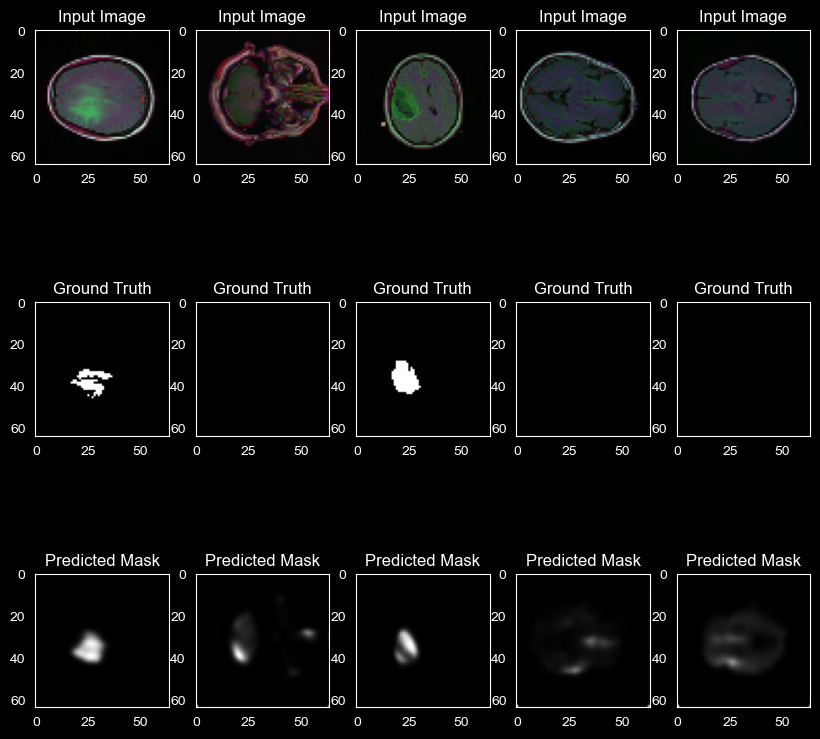

In [ ]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225] 
        labels = labels.to(device)
        with torch.no_grad():
            outputs = predict(images)
        # outputs[outputs < 0.5] = 0
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow((images[i].transpose(1, 2, 0)*std + mean).clip(0, 1))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")

visualize_predictions(hvae, test_loader)